In [1]:
import torch
import numpy as np
from model_creator import make_conv2d_model, mod
import tensorly as tl
import tensorly.decomposition as dc
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale, normalize
from sklearn.model_selection import cross_val_score
import torchvision.transforms as transforms
import torchvision
from pathlib import Path
from tqdm import tqdm
from collections import Counter
from utils import *
import matplotlib.pyplot as plt
tl.set_backend('pytorch')
device='cuda'
%load_ext autoreload
%autoreload 2

In [12]:
params = {}
params['n_conv_layers'] = 1
params['use_batch_norm'] = False
params['input_kernel_size'] = (5, 5)
params['conv_dim_change'] = 'double'
params['pool_size'] = (2, 2)
params['activation'] = 'relu'
params['n_dense_layers'] = 0
params['conv_kernel_size'] = (3, 3)
params['initial_kernel_number'] = 15
params['dense_dim'] = 100

In [3]:
# model = mod(*make_conv2d_model((3, 32, 32), 10, params)).to(device)

In [2]:
model = torchvision.models.wide_resnet50_2(pretrained=True)

In [4]:
model.fc = torch.nn.Linear(2048, 200)
experiment = 303
seed = 303
model_id = f"{experiment}_{seed}"
model_path = Path(f"outputs/experiment_{experiment}/data/{model_id}").rglob('*pt')
model_path = list(model_path)[0]
model.load_state_dict(torch.load(model_path))
model.to(device)
print('loaded')

loaded


In [5]:
conv_layers = [model.conv1]
for sequential in [model.layer1, model.layer2, model.layer3, model.layer4]:
    for bottleneck in sequential:
        conv_layers.extend([bottleneck.conv1, bottleneck.conv2, bottleneck.conv3])

In [7]:
conv_layers

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),


In [141]:
def calculate_vips(pls_model):
    t = pls_model.x_scores_
    w = pls_model.x_weights_
    q = pls_model.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(np.matmul(np.matmul(np.matmul(t.T,t),q.T), q)).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(np.matmul(s.T, weight))/total_s)
    return vips

In [65]:
cv = RepeatedKFold(n_splits=4, n_repeats=1)

In [25]:
batch_size = 32
data_dir = Path('tiny-imagenet-200')
data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4805, 0.4483, 0.3978), (0.263, 0.257, 0.267)),
])
valid_set = torchvision.datasets.ImageFolder(data_dir / 'val', data_transforms)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                           shuffle=False, pin_memory=True)
train_set = torchvision.datasets.ImageFolder(data_dir / 'train', data_transforms)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, pin_memory=True)

In [14]:
accuracy1 = [0.7387, 0.7353, 0.7293, 0.7217, 0.7170, 0.7204, 0.6724, 0.005]
accuracy2 = [0.7473, 0.7265, 0.7141, 0.7272, 0.7263, 0.7179, 0.7047, 0.005]
accuracy3 = [0.7384, 0.7312, 0.7256, 0.7108, 0.7291, 0.7045, 0.7090, 0.005]
pfilt = np.array([1, 9, 17, 25, 32, 40, 48, 53])/64

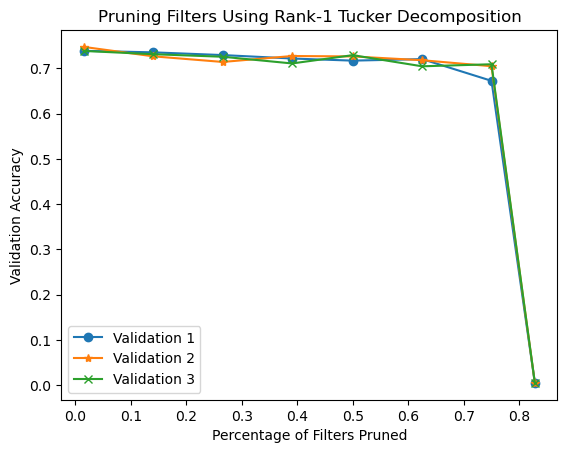

In [23]:
plt.plot(pfilt, accuracy1, marker='o', label='Validation 1')
plt.plot(pfilt, accuracy2, marker='*', label='Validation 2')
plt.plot(pfilt, accuracy3, marker='x', label='Validation 3')
plt.legend()
plt.title("Pruning Filters Using Rank-1 Tucker Decomposition")
plt.xlabel('Percentage of Filters Pruned')
plt.ylabel('Validation Accuracy')
plt.savefig("prune vs acc.png")

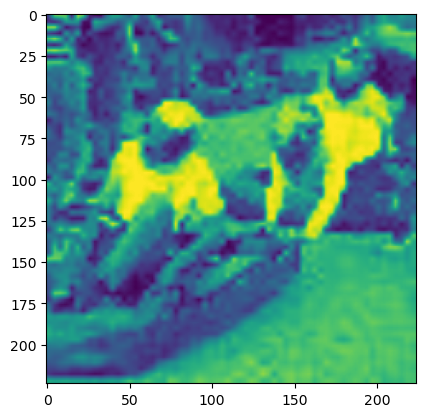

In [24]:
plt.imshow(valid_set[0][0][2])

In [141]:
def select_filters(model, valid_loader, valid_set, remove_amount):
    """
    worst : list of highest divergence filters (worst filters) across batches
            Can select top-k afterwards.
    imp   : list of divergences from tensor decomposition reconstruction.
            lower means filter is more important.
    """
    worst = []
    for i, data in tqdm(enumerate(valid_loader),
                        total=len(valid_set) / valid_loader.batch_size):
        out, y = data
        out = out.to(device)
        y = y
        for j, (name, param) in enumerate(model.named_children()):
            out = param(out)
            if j == 0:
                break
        nout = out.detach()

        cp = dc.tucker(nout, 25)
        pred = tl.tucker_tensor.tucker_to_tensor(cp)
        dist = torch.cdist(pred, nout)
        importance = torch.mean(dist, dim=[0, 2, 3])
        _, w = torch.topk(importance, remove_amount)
        worst.append(w)
        
        if i == 30:
            break
    return worst

In [142]:
worst = select_filters(model, valid_loader, valid_set, 3)

  0%|          | 0/312.5 [00:00<?, ?it/s]


AttributeError: 'Conv2d' object has no attribute 'size'

In [79]:
torch.argmax(torch.mean(torch.stack(imp, dim=0), dim=0))

tensor(8, device='cuda:0')

In [136]:
[k for k in Counter(torch.stack(worst).view(-1).cpu().numpy()).keys()]

[10, 3, 53]

In [135]:
for k in a.keys():
    print(a[k], k)

31 10
31 3
31 53


In [83]:
torch.min(torch.stack(imp))

In [72]:
model = torchvision.models.resnet18(pretrained=True)

In [73]:
TuckerStructured(model.conv1, name='weight', amount=0, dim=-2,filt=70)

torch.Size([64, 3, 7, 7]) 4
tensor([[[1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.]]])


Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [75]:
model.conv1.weight_mask[0]

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]])

In [490]:
# dataloader = iter(valid_loader)
x, y = next(dataloader)
x = x.to(device)
ny = y.numpy()

In [491]:
out = model(x)
nout = out.detach()

In [492]:
osample = nout[0]
print(osample.is_cuda)

True


In [503]:
cp = dc.tucker(osample, 22)

/opt/conda/lib/python3.7/site-packages/tensorly/tucker_tensor.py:357: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 3. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)


In [494]:
print(len(cp[1])) 

4


In [504]:
for i in range(len(cp[1])):
    print(cp[1][i].shape)

torch.Size([15, 15])
torch.Size([28, 22])
torch.Size([28, 22])


In [505]:
# pred = tl.cp_tensor.cp_to_tensor(cp)
pred = tl.tucker_tensor.tucker_to_tensor(cp)

In [506]:
pred.shape

torch.Size([15, 28, 28])

In [507]:
dist = torch.cdist(pred, osample)

In [508]:
dist.shape

torch.Size([15, 28, 28])

In [510]:
importance = torch.mean(dist, dim=[1, 2])

In [511]:
torch.argmin(importance)

tensor(0, device='cuda:0')

In [512]:
importance

tensor([0.6711, 1.2247, 1.7894, 0.7869, 2.0999, 1.8570, 1.0078, 1.4888, 0.9308,
        1.2620, 1.3241, 0.8901, 0.8965, 1.7836, 1.5718], device='cuda:0')

tensor([0.7249, 1.8099, 1.4779, 1.0375, 2.1402, 1.5931, 1.0717, 1.4681, 1.1761,
        1.3171, 1.2156, 1.6594, 1.1599, 2.0530, 1.3948], device='cuda:0')

In [479]:
# bigcp = cp
# imp = importance
print(imp)
torch.mean(torch.cdist(bigcp[1][0], cp[1][1]))

tensor([0.6309, 1.6372, 1.2259, 0.7888, 2.0096, 1.4350, 0.9153, 1.2241, 0.8291,
        1.1813, 1.0735, 1.5589, 0.9121, 1.8906, 1.2141], device='cuda:0')


tensor(7.8082, device='cuda:0')

In [477]:
bigcp[1][0].shape, cp[1][1].shape

(torch.Size([15, 22]), torch.Size([15, 22]))

In [426]:
a = torch.outer(torch.tensor(normalize([[1., 5, 0]])).squeeze(0),
                torch.tensor(normalize([[1., 1, 1]])).squeeze(0))
a += torch.outer(torch.tensor(normalize([[1., 50, 0]])).squeeze(0),
                torch.tensor(normalize([[1., 1, 1]])).squeeze(0))
c = torch.tensor(normalize([[0, 5, 1], [0, 5., 1], [5, 0, 5]]))

In [427]:
b = dc.parafac(c, 1)

/opt/conda/lib/python3.7/site-packages/tensorly/backend/core.py:885: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


In [428]:
pred = tl.cp_tensor.cp_to_tensor(b)

In [429]:
dist = torch.cdist(pred, c)

In [430]:
importance = torch.mean(dist, dim=[1])

In [431]:
importance

tensor([0.4884, 0.4884, 0.8133], dtype=torch.float64)

In [432]:
pred

tensor([[0.0913, 0.9467, 0.2806],
        [0.0913, 0.9467, 0.2806],
        [0.0244, 0.2532, 0.0751]], dtype=torch.float64)

In [433]:
dist

tensor([[0.1289, 0.1289, 1.2072],
        [0.1289, 0.1289, 1.2072],
        [0.7378, 0.7378, 0.9642]], dtype=torch.float64)

In [403]:
b[1]

[tensor([[5.0990],
         [5.0990],
         [5.0990]]),
 tensor([[0.0000],
         [0.9806],
         [0.1961]])]